# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install lightgbm

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import re
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
RANDOM_STATE = 12345

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описание данных

<br>Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с- .)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<br>Целевой признак

- Price — цена (евро)

In [7]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Приведем названия столбцов к змеиной нотации

In [8]:
def snake_case(column_name):
    column_name = re.sub(r'([a-z])([A-Z])', r'\1_\2', column_name).lower()
    return column_name

data = data.rename(columns=snake_case)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
# Проверка на дубликаты
duplicates = data.duplicated()
print("Количество дубликатов:", duplicates.sum())
print()
# Проверка на уникальные значения для каждого столбца
unique_values = data.nunique()
print("Уникальные значения по столбцам:\n", unique_values)
print()
# Проверка на пропущенные значения для каждого столбца
missing_values = data.isnull().sum()
print("Пропущенные значения по столбцам:\n", missing_values)

Количество дубликатов: 4

Уникальные значения по столбцам:
 date_crawled          271174
price                   3731
vehicle_type               8
registration_year        151
gearbox                    2
power                    712
model                    250
kilometer                 13
registration_month        13
fuel_type                  7
brand                     40
repaired                   2
date_created             109
number_of_pictures         1
postal_code             8143
last_seen             179150
dtype: int64

Пропущенные значения по столбцам:
 date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_se

In [11]:
data.drop_duplicates(inplace=True)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registration_year'}>,
        <AxesSubplot:title={'center':'power'}>],
       [<AxesSubplot:title={'center':'kilometer'}>,
        <AxesSubplot:title={'center':'registration_month'}>,
        <AxesSubplot:title={'center':'number_of_pictures'}>],
       [<AxesSubplot:title={'center':'postal_code'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

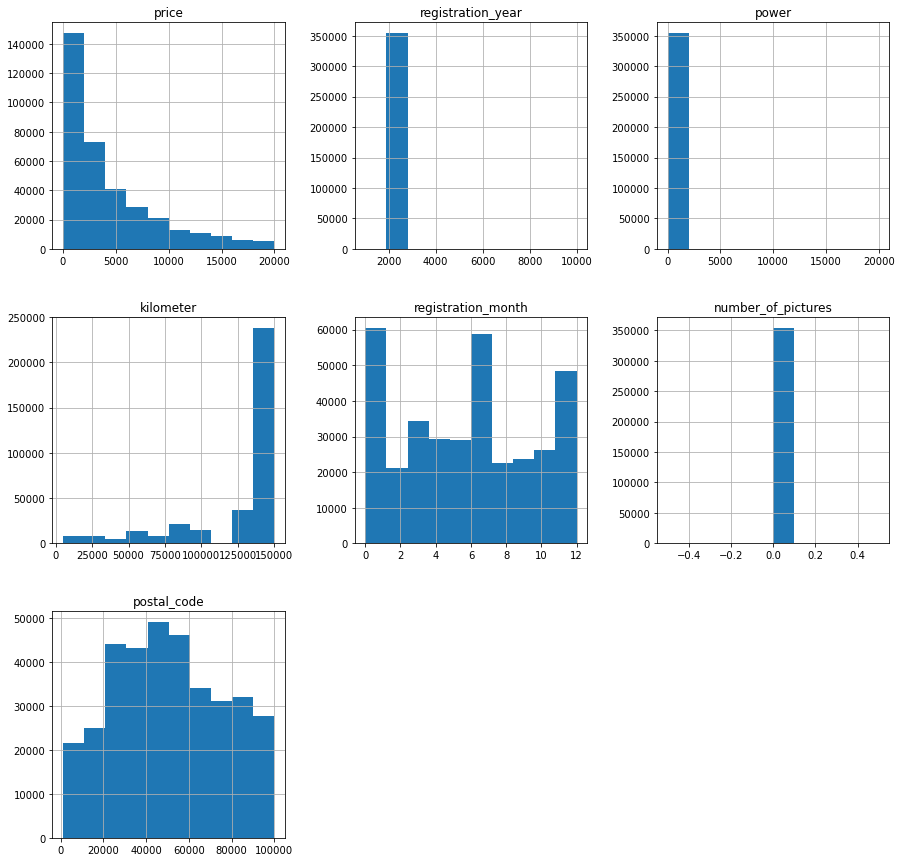

In [12]:
data.hist(figsize=(15, 15))

In [13]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [14]:
df = data.copy()

Рассмотрим столбцы с пропусками

In [15]:
columns_with_missing_values = df.columns[df.isnull().any()]
for column in columns_with_missing_values:
    unique_values = df[column].unique()
    print(f"Столбец '{column}': Уникальные значения: {unique_values}")

Столбец 'vehicle_type': Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Столбец 'gearbox': Уникальные значения: ['manual' 'auto' nan]
Столбец 'model': Уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii

Отсутствуют значения в категориальных переменных. Что бы не исказить результаты заменим пропущенные значения на "unknown"

In [16]:
df=df.fillna('unknown')
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Рассмотрим столбцы с датами

In [17]:
# Преобразование столбцов с датами в тип datetime
date_cols = ['date_crawled', 'date_created', 'last_seen']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

print(df[date_cols].head(5))
print(df[date_cols].dtypes)

         date_crawled date_created           last_seen
0 2016-03-24 11:52:17   2016-03-24 2016-04-07 03:16:57
1 2016-03-24 10:58:45   2016-03-24 2016-04-07 01:46:50
2 2016-03-14 12:52:21   2016-03-14 2016-04-05 12:47:46
3 2016-03-17 16:54:04   2016-03-17 2016-03-17 17:40:17
4 2016-03-31 17:25:20   2016-03-31 2016-04-06 10:17:21
date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object


In [18]:
min_dates = df[date_cols].min()
max_dates = df[date_cols].max()

print("Минимальные даты:")
print(min_dates)
print()
print("Максимальные даты:")
print(max_dates)

Минимальные даты:
date_crawled   2016-03-05 14:06:22
date_created   2014-03-10 00:00:00
last_seen      2016-03-05 14:15:08
dtype: datetime64[ns]

Максимальные даты:
date_crawled   2016-04-07 14:36:58
date_created   2016-04-07 00:00:00
last_seen      2016-04-07 14:58:51
dtype: datetime64[ns]


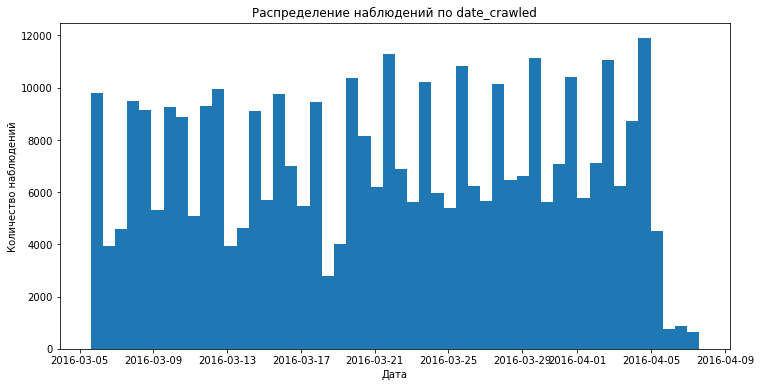

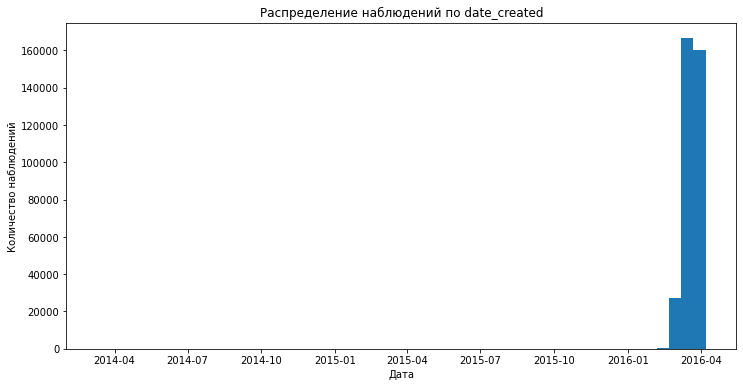

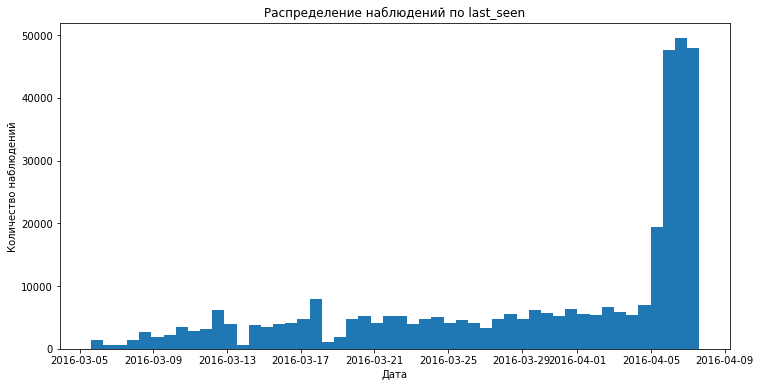

In [19]:
# Функция для построения графика распределения наблюдений по дате
def plot_date_distribution(column):
    plt.figure(figsize=(12, 6))
    plt.hist(df[column], bins=50)
    plt.xlabel('Дата')
    plt.ylabel('Количество наблюдений')
    plt.title(f'Распределение наблюдений по {column}')
    plt.show()

# Построение графиков для каждого столбца с датой
for col in date_cols:
    plot_date_distribution(col)

Можно сделать вывод, что компания начала с конца 2015 года. 

Исходя из предоставленного списка данных, визуально можно выделить несколько столбцов, которые не влияют на цену.

- date_crawled: Дата скачивания анкеты из базы. Эта информация не представляет особой ценности для анализа данных или моделирования, так как она отражает только момент скачивания анкеты, который может быть случайным.

- date_crawled: Дата создания анкеты. Аналогично предыдущему столбцу, эта информация может быть несущественной для исследования, если она не имеет прямого отношения к анализу автомобилей или их цены.

- last_seen: Дата последней активности пользователя. Данный столбец отражает только момент последнего доступа пользователя к анкете, что не является важным фактором для анализа автомобилей или их цены.

- number_of_pictures: Количество фотографий автомобиля. В данном датасете значение этого столбца равно 0 для всех записей, что говорит о том, что отсутствуют фотографии. Таким образом, этот столбец не несет информации и может быть удален.

- postal_code: Почтовый индекс владельца анкеты. Данный столбец может иметь некоторую информативность, но в контексте анализа цены автомобилей он не является важным. 

- registration_month: месяц регистрации автомобиля. Данный столбец не влияет на стоимость автомобиля.

In [20]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code', 'registration_month'], axis=1)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Рассмотрим аномальные значения**

In [21]:
def plot_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['int64']).columns

    for column in numeric_columns:
        plt.figure(figsize=(15, 5))
        df[column].hist(bins=200)
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()

        plt.figure(figsize=(15, 3))
        sns.boxplot(data=df[column], orient='h')
        plt.title(f'Ящик с усами для {column}')
        plt.xlabel(column)
        plt.show()

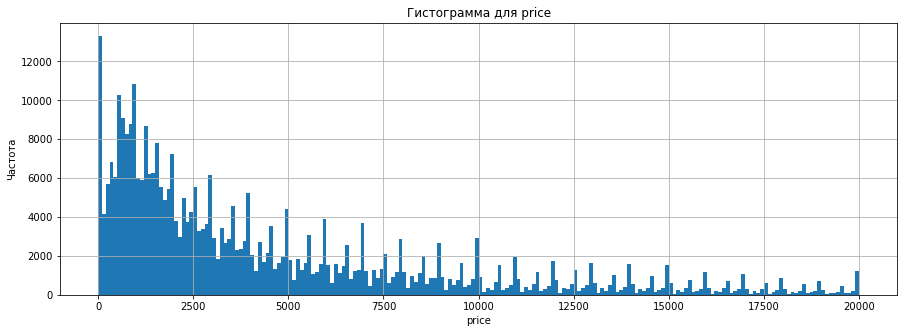

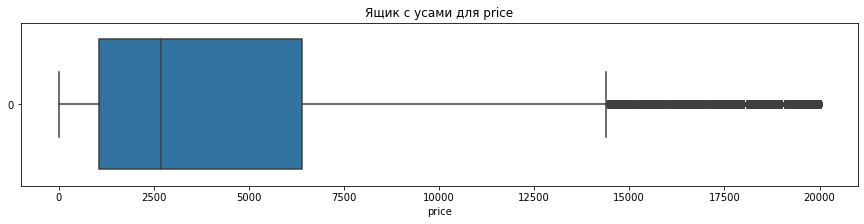

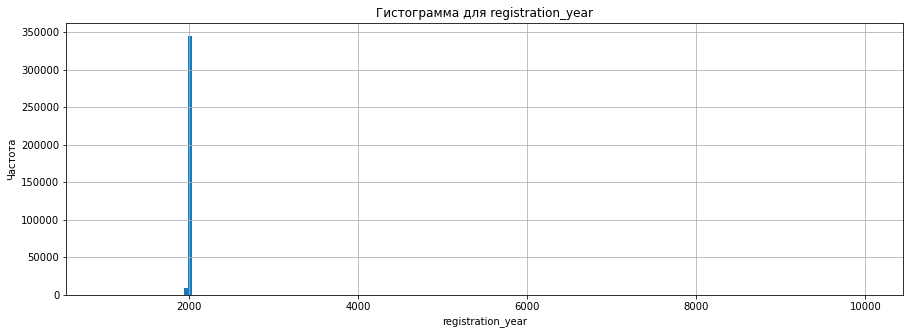

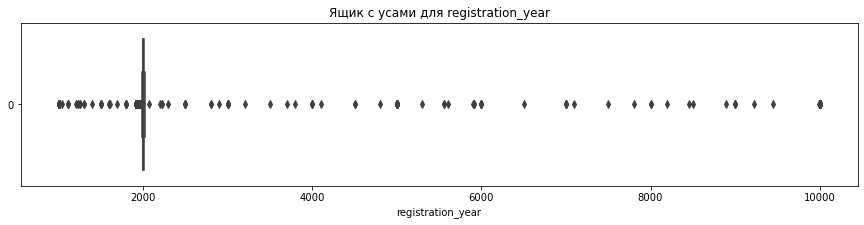

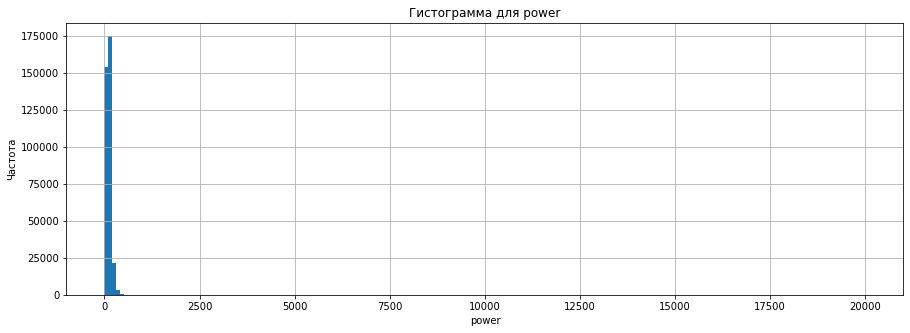

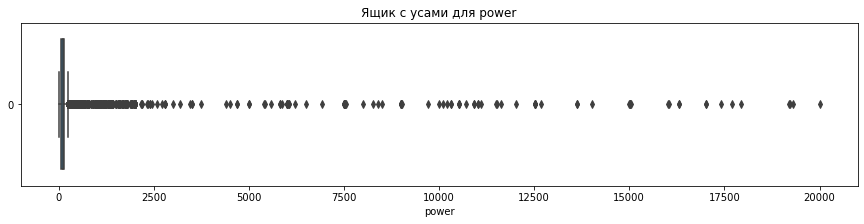

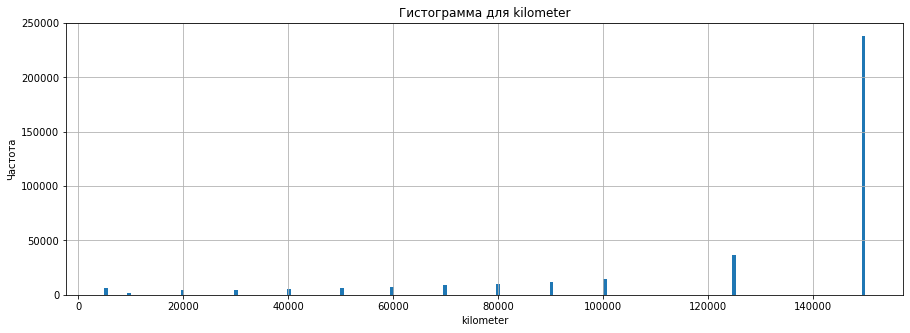

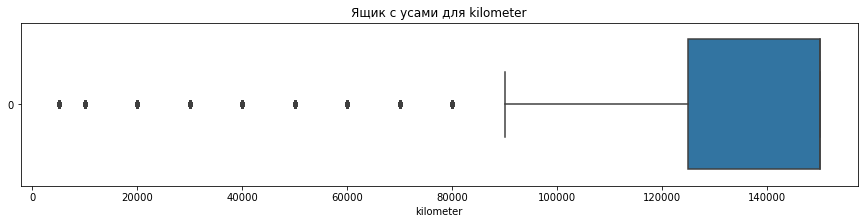

In [22]:
plot_numeric_columns(df)

**Признак price**

In [23]:
df.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [24]:
df = df[df['price'] != 0]

In [25]:
quantiles_price = df['price'].quantile([0.05, 0.95])
quantiles_price

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [26]:
# Подсчет доли значений меньше 0.05
fraction_less_than_0_05 = df[df['price'] < quantiles_price[0.05]].shape[0] / len(df)

# Подсчет доли значений больше 0.95
fraction_greater_than_0_95 = df[df['price'] > quantiles_price[0.95]].shape[0] / len(df)

print("Доля значений меньше", quantiles_price[0.05], ":", fraction_less_than_0_05)
print("Доля значений больше", quantiles_price[0.95], ":", fraction_greater_than_0_95)

Доля значений меньше 350.0 : 0.0453123317413335
Доля значений больше 14800.0 : 0.04986131847854875


In [27]:
df = df.query(f'{quantiles_price[0.05]} <= price <= {quantiles_price[0.95]}')

**Признак registration_year**

In [28]:
df.registration_year.value_counts()

2000    20907
2005    20811
1999    20621
2003    19217
2001    19091
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 130, dtype: int64

In [29]:
min_year = df['registration_year'].min()
max_year = df['registration_year'].max()

print("Минимальный год регистрации:", min_year)
print("Максимальный год регистрации:", max_year)

Минимальный год регистрации: 1000
Максимальный год регистрации: 9999


До этого мы посмотрели максимальные даты:
- date_crawled   2016-04-07 14:36:58
- date_created   2016-04-07 00:00:00
- last_seen      2016-04-07 14:58:51
<br>Следовательно можно удалить автомобили с годом регистрации после 2016 года и до 1900.

In [30]:
df = df[(df['registration_year'] >= 1890) & (df['registration_year'] <= 2016)]

**Признак power**


In [31]:
df.power.value_counts()

0        27306
75       20682
60       13099
150      13029
101      12116
         ...  
678          1
4400         1
1703         1
9013         1
17019        1
Name: power, Length: 633, dtype: int64

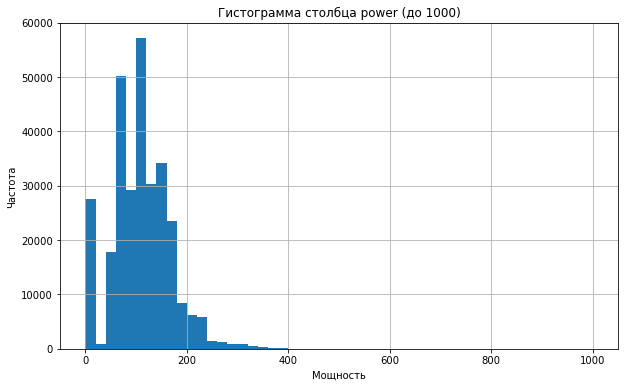

In [32]:
plt.figure(figsize=(10, 6))
df['power'].hist(bins=50, range=(0, 1000))
plt.title('Гистограмма столбца power (до 1000)')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

In [33]:
df = df[(df['power'] > 0) & (df['power'] <= 1000)]

**Вывод**
- Данные были обработаны
- Наименования признаков привели к "змеиному" стилю
- Убрали аномальные значения 
- Убрали столбцы, не влияющие на цену
- Удалили 4 полных дубликата 

## Обучение моделей

In [34]:
features = df.drop('price', axis=1)
target = df['price']

Разобьем выборку на обучающую и тестовую

In [35]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

# Проверим размер выборок
print('train', len(features_train), len(target_train))
print('test', len(features_test), len(target_test))

train 202653 202653
test 67552 67552


In [36]:
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical_features = ['registration_year', 'power', 'kilometer']

In [37]:
# Прямое кодирование категориальных признаков 
features_train_ohe = pd.get_dummies(features_train, columns=categorical_features, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, columns=categorical_features, drop_first=True)

# Удаление лишних признаков
common_columns = set(features_train_ohe.columns) & set(features_test_ohe.columns)
features_train_ohe = features_train_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

 Обучение моделей и поиск лучших параметров

In [43]:
# Обучение моделей и поиск лучших параметров
start_time = time.time()
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05]}
grid_search_lgbm = GridSearchCV(model_lgbm, params_lgbm, scoring='neg_mean_squared_error', cv=2)
grid_search_lgbm.fit(features_train_ohe, target_train)

model_ridge = Ridge(random_state=RANDOM_STATE)
params_ridge = {'alpha': [0.1, 1.0, 10.0]}
grid_search_ridge = GridSearchCV(model_ridge, params_ridge, scoring='neg_mean_squared_error', cv=2)
grid_search_ridge.fit(features_train_ohe, target_train)

model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=categorical_features)
params_catboost = {'iterations': [100, 200, 300], 'learning_rate': [0.1, 0.05]}
grid_search_catboost = GridSearchCV(model_catboost, params_catboost, scoring='neg_mean_squared_error', cv=2)
grid_search_catboost.fit(features_train, target_train)

# Получение результатов по каждой модели и лучших параметров
results = pd.DataFrame({
    'Модель': ['LightGBM', 'Ridge', 'CatBoost'],
    'Лучшие параметры': [
        grid_search_lgbm.best_params_,
        grid_search_ridge.best_params_,
        grid_search_catboost.best_params_
    ]
})

# Вывод результатов
print(results)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

0:	learn: 3363.6687400	total: 203ms	remaining: 20.1s
1:	learn: 3165.5577789	total: 248ms	remaining: 12.2s
2:	learn: 2997.0338581	total: 296ms	remaining: 9.56s
3:	learn: 2847.2729536	total: 338ms	remaining: 8.12s
4:	learn: 2712.5895278	total: 387ms	remaining: 7.35s
5:	learn: 2592.3903168	total: 431ms	remaining: 6.75s
6:	learn: 2485.7764568	total: 479ms	remaining: 6.36s
7:	learn: 2392.1765979	total: 521ms	remaining: 6s
8:	learn: 2311.3788184	total: 565ms	remaining: 5.71s
9:	learn: 2242.4371240	total: 609ms	remaining: 5.48s
10:	learn: 2171.6285291	total: 655ms	remaining: 5.3s
11:	learn: 2106.9925449	total: 697ms	remaining: 5.11s
12:	learn: 2052.5933308	total: 740ms	remaining: 4.95s
13:	learn: 2005.3128435	total: 782ms	remaining: 4.81s
14:	learn: 1964.8256061	total: 826ms	remaining: 4.68s
15:	learn: 1926.4216274	total: 871ms	remaining: 4.57s
16:	learn: 1895.4977503	total: 915ms	remaining: 4.47s
17:	learn: 1866.2479013	total: 957ms	remaining: 4.36s
18:	learn: 1840.4044254	total: 999ms	remai

## Анализ моделей

In [44]:
# Вычисление RMSE с помощью кросс-валидации на тренировочной выборке
rmse_lgbm = (-grid_search_lgbm.best_score_) ** 0.5
rmse_ridge = (-grid_search_ridge.best_score_) ** 0.5
rmse_catboost = (-grid_search_catboost.best_score_) ** 0.5

# Создание таблицы результатов
results = pd.DataFrame({
    'Модель': ['LightGBM', 'Ridge', 'CatBoost'],
    'RMSE': [rmse_lgbm, rmse_ridge, rmse_catboost]
})

# Вывод результатов
print(results)


     Модель         RMSE
0  LightGBM  1349.397710
1     Ridge  2127.075241
2  CatBoost  1389.725109


**Вывод**
Лучшие показатели скорости у модели  LightGBM

## Тестирование лучшей модели

In [46]:
best_model = grid_search_lgbm.best_estimator_
predictions = best_model.predict(features_test_ohe)
final_rmse = mean_squared_error(target_test, predictions, squared=False)

print("Финальная метрика RMSE на тестовой выборке:", final_rmse)

Финальная метрика RMSE на тестовой выборке: 1338.3835744078613


In [47]:
# Проверка требования к финальной метрике
if final_rmse <= 2500:
    print("Финальная модель удовлетворяет требованиям")
else:
    print("Финальная модель не удовлетворяет требованиям")

Финальная модель удовлетворяет требованиям


In [48]:
# Рекомендация заказчику наиболее подходящей модели
best_model_name = results.loc[results['RMSE'].idxmin(), 'Модель']
print("Наиболее подходящая модель для заказчика:", best_model_name)

Наиболее подходящая модель для заказчика: LightGBM


##  Вывод
В проекте:

- загрузила данные и провела их предобработку - очистку, заполнение, удаление лишних данных
- сравнила 3 модели с разными гиперпараметрами и выборками
- выбрала лучшую модель по 3 показателям - RMSE, время обучения и время предскзания. И проверила ее на тестовой выборке

Итог - наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1338, несмотря на требуемое бОльшее время на обучение и предсказание. 